In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

# Logistic Regression on Churn Data

### Load and preprocess data

In [2]:
X_train = pd.read_csv("x_train.csv")
X_test = pd.read_csv("x_test.csv")
y_train = pd.read_csv("y_train.csv")['churn']
y_test = pd.read_csv("y_test.csv")['churn']
X_train = X_train[X_train.columns.drop(list(X_train.filter(regex='col')))]
X_test = X_test[X_test.columns.drop(list(X_test.filter(regex='col')))]

### Use GridSearch Cross Validation to get best parameters for Logistic Regression

In [3]:
param_map = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10]}
clf = LogisticRegression(class_weight='balanced', random_state=0, max_iter=10000, solver='liblinear')  
clf_gs = GridSearchCV(clf, param_grid=param_map, cv=5, n_jobs=-1, verbose=1) #n_jobs=-1 enables parallel processing to reduce run time
clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=0,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [4]:
print("Best estimator:\n",clf_gs.best_estimator_)
print("\nBest score:\n",clf_gs.best_score_)
print("\nBest parameters:\n",clf_gs.best_params_)

Best estimator:
 LogisticRegression(C=10, class_weight='balanced', max_iter=10000,
                   random_state=0, solver='liblinear')

Best score:
 0.73

Best parameters:
 {'C': 10, 'penalty': 'l2'}


In [5]:
best_log = clf_gs.best_estimator_
coef = np.transpose(best_log.coef_)
summary = pd.DataFrame(zip(X_train.columns, coef), columns=['features', 'coef']) 
summary['coef'] = [elem[0] for elem in summary['coef']]
sorted_summary = summary.sort_values(by=['coef'], ascending=False, key=abs)
sorted_summary = sorted_summary[abs(sorted_summary['coef']) >= 0.001]
sorted_summary

features      coef
1              international_plan  2.316586
2                 voice_mail_plan -1.096008
18                  area_code_415 -0.896376
6                total_day_charge -0.829511
17                  area_code_408 -0.697211
19                  area_code_510 -0.634664
16  number_customer_service_calls -0.179342
4               total_day_minutes  0.150458
12             total_night_charge  0.119554
14               total_intl_calls -0.086850
9                total_eve_charge -0.080131
13             total_intl_minutes  0.045353
7               total_eve_minutes  0.010586
15              total_intl_charge -0.009351
11              total_night_calls -0.004584
3           number_vmail_messages  0.002524
10            total_night_minutes -0.001937

### Build final model using best parameters and top features

In [6]:
top_features = list(sorted_summary['features'].sort_index())
x_train_filtered = X_train[top_features]
x_test_filtered = X_test[top_features]

log_best_feat = clf_gs.best_estimator_
results = log_best_feat.fit(x_train_filtered, y_train)

coef = np.transpose(log_best_feat.coef_)
summary = pd.DataFrame(zip(x_train_filtered.columns, coef), columns=['features', 'coef']) 
summary['coef'] = [elem[0] for elem in summary['coef']]
summary

features      coef
0              international_plan  2.330009
1                 voice_mail_plan -1.142060
2           number_vmail_messages  0.003996
3               total_day_minutes  0.075354
4                total_day_charge -0.387923
5               total_eve_minutes  0.004660
6                total_eve_charge -0.010811
7             total_night_minutes  0.002787
8               total_night_calls -0.004747
9              total_night_charge  0.013946
10             total_intl_minutes  0.039900
11               total_intl_calls -0.087288
12              total_intl_charge  0.007371
13  number_customer_service_calls -0.180425
14                  area_code_408 -0.639836
15                  area_code_415 -0.840101
16                  area_code_510 -0.581087

### Evaluate model

In [7]:
def show_results(y_true, y_pred, thresh, data_type):
    print(f"Accuracy for {data_type} data:\n", metrics.accuracy_score(y_true, y_pred))

    print(f"Classification report\n",metrics.classification_report(y_true, y_pred))

    print(f"Confusion matrix\n", metrics.confusion_matrix(y_true, y_pred))

Find the best threshold to classify churn as "yes". We used a combination of overall accuracy and the f1-score to find the best classification threshold.

In [8]:
def custom_predict(X, threshold):
    probs = log_best_feat.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

best_thresh = -1
best_acc = -1
for i in np.arange(0, 1, 0.001):
    new_train_preds = custom_predict(X=x_train_filtered, threshold=i) 
    acc = metrics.accuracy_score(y_train, new_train_preds) * metrics.f1_score(y_train, new_train_preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = i
        
print("Best threshold:", round(best_thresh,7))

Best threshold: 0.548


In [9]:
best_thresh = round(best_thresh,7)
new_train_preds = custom_predict(X=x_train_filtered, threshold=best_thresh) 

show_results(y_train, new_train_preds, best_thresh, "train")

Accuracy for train data:
 0.7501960784313726
Classification report
               precision    recall  f1-score   support

           0       0.72      0.83      0.77      2550
           1       0.80      0.67      0.73      2550

    accuracy                           0.75      5100
   macro avg       0.76      0.75      0.75      5100
weighted avg       0.76      0.75      0.75      5100

Confusion matrix
 [[2113  437]
 [ 837 1713]]


In [10]:
test_pred = custom_predict(X=x_test_filtered, threshold=best_thresh) 

show_results(y_test, test_pred, best_thresh, "test")

# print(f"\n{metrics.f1_score(y_test, test_pred)}")

# print(f"\n{metrics.precision_score(y_test, test_pred)}")

# print(f"\n{metrics.recall_score(y_test, test_pred)}")

Accuracy for test data:
 0.7450090744101633
Classification report
               precision    recall  f1-score   support

           0       0.71      0.84      0.77      1102
           1       0.80      0.65      0.72      1102

    accuracy                           0.75      2204
   macro avg       0.75      0.75      0.74      2204
weighted avg       0.75      0.75      0.74      2204

Confusion matrix
 [[928 174]
 [388 714]]


The test dataset did not see a drop in accuracy or f1-score from the train dataset.

AUC score: 0.7770321902760531


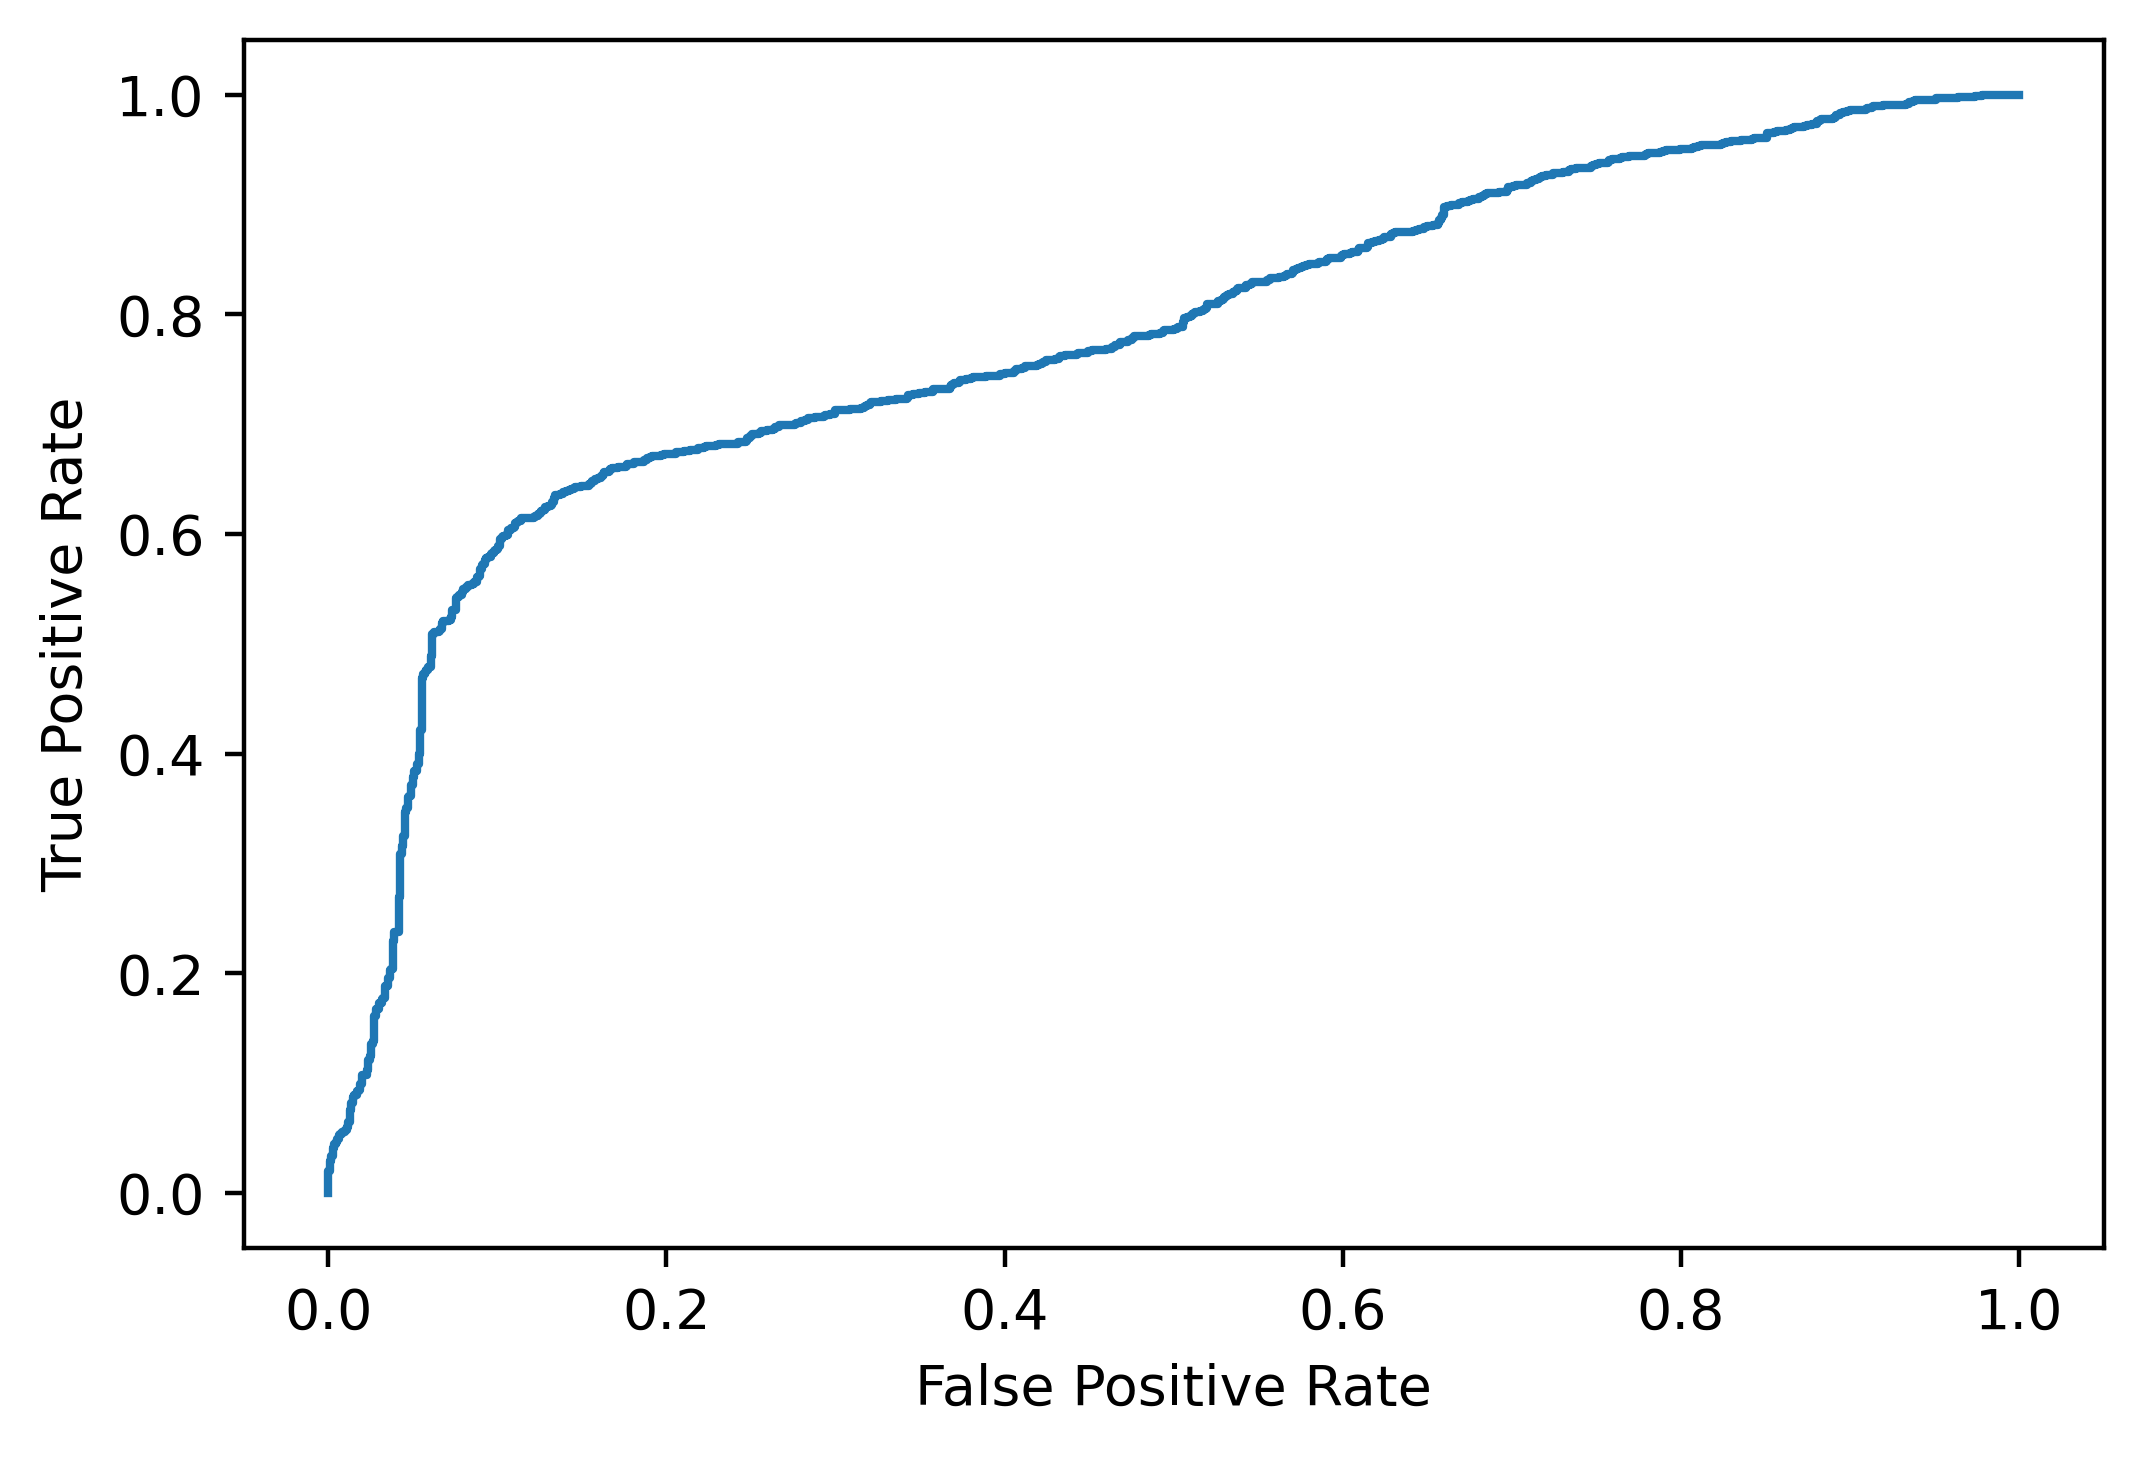

In [11]:
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.figure(dpi=400)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

y_proba = log_best_feat.predict_proba(x_test_filtered)[:, 1]
plot_roc_curve(y_test, y_proba)
print(f'AUC score: {metrics.roc_auc_score(y_test, y_proba)}')

### Applying PCA

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_pca = sc.fit_transform(X_train)
X_test_pca = sc.transform(X_test)

In [13]:
from sklearn.decomposition import PCA
  
pca = PCA(n_components=15, random_state=0)
  
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

In [14]:
log_best = LogisticRegression(random_state=0)
log_best.fit(X_train_pca, y_train)

def custom_predict(X, threshold):
    probs = log_best.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

best_thresh = -1
best_acc = -1
for i in np.arange(0, 1, 0.001):
    new_train_preds = custom_predict(X=X_train_pca, threshold=i) 
    acc = metrics.accuracy_score(y_train, new_train_preds) * metrics.f1_score(y_train, new_train_preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = i
        
print("Best threshold:", round(best_thresh,7), "\n")

best_thresh = round(best_thresh,7)
y_train_pred = custom_predict(X=X_train_pca, threshold=best_thresh) 

show_results(y_train, y_train_pred, best_thresh, "train")

print(" ")

y_test_pred = custom_predict(X=X_test_pca, threshold=best_thresh) 

show_results(y_test, y_test_pred, best_thresh, "test")

Best threshold: 0.556 

Accuracy for train data:
 0.7513725490196078
Classification report
               precision    recall  f1-score   support

           0       0.71      0.84      0.77      2550
           1       0.80      0.67      0.73      2550

    accuracy                           0.75      5100
   macro avg       0.76      0.75      0.75      5100
weighted avg       0.76      0.75      0.75      5100

Confusion matrix
 [[2136  414]
 [ 854 1696]]
 
Accuracy for test data:
 0.7477313974591652
Classification report
               precision    recall  f1-score   support

           0       0.70      0.85      0.77      1102
           1       0.81      0.64      0.72      1102

    accuracy                           0.75      2204
   macro avg       0.76      0.75      0.74      2204
weighted avg       0.76      0.75      0.74      2204

Confusion matrix
 [[940 162]
 [394 708]]


Applying PCA to the Logistic Regression model improved its accuracy slightly, but did not make much of a difference.